# Train Detectron2 with Custom COCO Datasets

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import gdown
import torch

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Register your own data set in coco format

In [2]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances('subt_train', {}, 
                        '/home/arg/detectron2/datasets/subt-urban-coco-dataset/SubT_urban_train.json', 
                       '/home/arg/detectron2/datasets/subt-urban-coco-dataset/SubT_urban_train')
register_coco_instances('subt_val', {}, 
                        '/home/arg/detectron2/datasets/subt-urban-coco-dataset/SubT_urban_val.json', 
                       '/home/arg/detectron2/datasets/subt-urban-coco-dataset/SubT_urban_val')

In [3]:
subt_metadata = MetadataCatalog.get("subt_val")
dataset_dicts = DatasetCatalog.get("subt_val")
subt_metadata


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Metadata(evaluator_type='coco', image_root='/home/arg/detectron2/datasets/subt-urban-coco-dataset/SubT_urban_val', json_file='/home/arg/detectron2/datasets/subt-urban-coco-dataset/SubT_urban_val.json', name='subt_val', thing_classes=['_background_', 'backpack', 'vent', 'phone', 'suvivor'], thing_dataset_id_to_contiguous_id={0: 0, 1: 1, 2: 2, 3: 3, 4: 4})

## Visualize dataset - make sure the data is loaded without problems

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset.

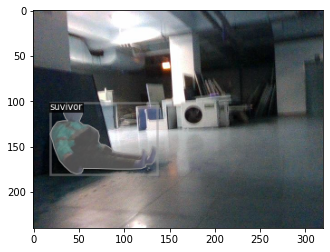

In [4]:
import random

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=subt_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1], cmap='nipy_spectral')
    cv2.waitKey(0)

## Change configuration parameters
Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the dataset.

In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("subt_train",)
cfg.DATASETS.TEST = ("subt_val", )
cfg.DATALOADER.NUM_WORKERS = 0 #Single thread
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # datasets classes
cfg.SOLVER.IMS_PER_BATCH = 6 #Batch size
ITERS_IN_ONE_EPOCH = 610 #dataset_imgs/batch_size  
cfg.SOLVER.MAX_ITER = (ITERS_IN_ONE_EPOCH * 50) # ITERS

cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.CHECKPOINT_PERIOD = ITERS_IN_ONE_EPOCH #Save training model interval


## Training


In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(False)
trainer.train()

## Make a prediction

Download a pre-trained SubT model

In [6]:
models_url = "https://drive.google.com/a/g2.nctu.edu.tw/uc?id=1LjW4-4YAL81TXkxL9tzm0NaiOhuJVpNg&export=download"
models_name = "model_0096989.pth"
if not os.path.isfile("output/" + models_name):
    gdown.download(models_url, output="output/" + models_name, quiet=False)

print("Finished downloading models.") 

Finished downloading models.


In [7]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0096989.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("subt_val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.


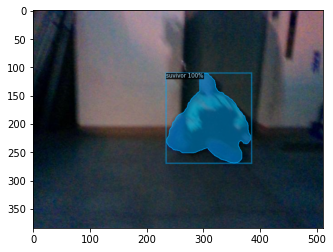

In [8]:
from detectron2.utils.visualizer import ColorMode
import random

for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=subt_metadata, 
                   scale=0.8, 
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1], cmap='nipy_spectral')